In [79]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os

load_dotenv()
def set_env_vars(var):
    os.environ[var] = os.getenv(var)


vars = ["OPENAI_API_KEY", "LANGCHAIN_API_KEY", "LANGCHAIN_TRACING_V2", "LANGCHAIN_ENDPOINT", "LANGCHAIN_PROJECT", "TAVILY_API_KEY"]

for var in vars:
    set_env_vars(var)

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


In [2]:
from pydantic import BaseModel, Field
from typing import List

class Memory(BaseModel):
    content: str =  Field(..., description="The main content of the memory. For example: User expressed interest in learning about French.")

class MemoryCollection(BaseModel):
    memories: List[Memory] = Field(..., description="A list of memories. Each memory is a string.")



In [3]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

structured_llm = llm.with_structured_output(MemoryCollection)

memory_collection = structured_llm.invoke([HumanMessage(content="Hi I am Hrithik! I like to bike.")])


In [12]:
print(memory_collection.memories[0].model_dump())
print("---------------------------------------------------")
print(memory_collection.memories[1].model_dump())

{'content': "User's name is Hrithik."}
---------------------------------------------------
{'content': 'User likes to bike.'}


In [15]:
from uuid import uuid4
from langgraph.store.memory import InMemoryStore

store = InMemoryStore()

user_id = "1"

namespace= (user_id, "memories")

key1 = str(uuid4())
value1 = memory_collection.memories[0].model_dump()
key2 = str(uuid4())
value2 = memory_collection.memories[1].model_dump()

store.put(namespace, key1, value1)
store.put(namespace, key2, value2)


In [18]:
for m in store.search(namespace):
    print(m.dict())
    print("---------------------------------------------------")

{'namespace': ['1', 'memories'], 'key': 'ce69a6d0-878a-4f88-8559-5751237eaf66', 'value': {'content': "User's name is Hrithik."}, 'created_at': '2025-01-07T08:34:20.019069+00:00', 'updated_at': '2025-01-07T08:34:20.019071+00:00', 'score': None}
---------------------------------------------------
{'namespace': ['1', 'memories'], 'key': '49919b0f-734d-437c-9be7-e3d2037f4136', 'value': {'content': 'User likes to bike.'}, 'created_at': '2025-01-07T08:34:20.019096+00:00', 'updated_at': '2025-01-07T08:34:20.019097+00:00', 'score': None}
---------------------------------------------------


In [80]:
from trustcall import create_extractor

trustcall_extractor = create_extractor(
    llm, 
    tools=[Memory], 
    tool_choice = "Memory", 
    enable_inserts=True,
)

instruction = """ Extract memories from the following conversation: """

conversation = [HumanMessage(content="Hi, I'm Lance."), 
                AIMessage(content="Nice to meet you, Lance."), 
                HumanMessage(content="This morning I had a nice bike ride in San Francisco.")]

response = trustcall_extractor.invoke({"messages" : [SystemMessage(content=instruction)] + conversation})

In [81]:
response

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_MxxLFMDLKiOSjXW9Nervy4Nk', 'function': {'arguments': '{"content":"User had a nice bike ride in San Francisco this morning."}', 'name': 'Memory'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 109, 'total_tokens': 126, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'stop', 'logprobs': None}, id='run-749efc4b-8806-44a0-bf1f-da312d17bd0f-0', tool_calls=[{'name': 'Memory', 'args': {'content': 'User had a nice bike ride in San Francisco this morning.'}, 'id': 'call_MxxLFMDLKiOSjXW9Nervy4Nk', 'type': 'tool_call'}], usage_metadata={'input_tokens': 109, 'output_tokens': 17, 'total_tokens': 12

In [82]:
for m in response["messages"]:
    m.pretty_print()
    print("---------------------------------------------------")

================================== Ai Message ==================================
Tool Calls:
  Memory (call_MxxLFMDLKiOSjXW9Nervy4Nk)
 Call ID: call_MxxLFMDLKiOSjXW9Nervy4Nk
  Args:
    content: User had a nice bike ride in San Francisco this morning.
---------------------------------------------------


In [83]:
for m in response["responses"]:
    print(m)
    print("---------------------------------------------------")

content='User had a nice bike ride in San Francisco this morning.'
---------------------------------------------------


In [84]:
for m in response["response_metadata"]:
    print(m)
    print("---------------------------------------------------")

{'id': 'call_MxxLFMDLKiOSjXW9Nervy4Nk'}
---------------------------------------------------


In [85]:
updated_conversation = [AIMessage(content="That's great, did you do after?"), 
                        HumanMessage(content="I went to Tartine and ate a croissant."),                        
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about my Japan, and going back this winter!"),]

system_message = """ Update existing memories or create new ones based on the following conversations: """



In [86]:
tool_name = "Memory"
existing_memories = [(str(i) , tool_name , m.model_dump()) for i, m in enumerate(response["responses"])]
existing_memories



[('0',
  'Memory',
  {'content': 'User had a nice bike ride in San Francisco this morning.'})]

In [99]:
result = trustcall_extractor.invoke({"messages" : [SystemMessage(content=system_message)] + updated_conversation, "existing" : existing_memories})

In [100]:
result

{'messages': [AIMessage(content='', additional_kwargs={'updated_docs': {'call_OAc1wm2goAdo9yHPJHzEJhAQ': '1'}}, response_metadata={}, id='ae2af865-8912-44da-87df-457161733b92', tool_calls=[{'name': 'Memory', 'args': {'content': 'User is planning to go to Japan in January.'}, 'id': 'call_OAc1wm2goAdo9yHPJHzEJhAQ', 'type': 'tool_call'}, {'name': 'Memory', 'args': {'content': 'User is planning to go to Japan in January.'}, 'id': 'call_1bmQTTEyM8h0D1VrScuwM0u5', 'type': 'tool_call'}])],
 'responses': [Memory(content='User is planning to go to Japan in January.'),
  Memory(content='User is planning to go to Japan in January.')],
 'response_metadata': [{'id': 'call_OAc1wm2goAdo9yHPJHzEJhAQ',
   'json_doc_id': '1'},
  {'id': 'call_1bmQTTEyM8h0D1VrScuwM0u5'}],
 'attempts': 1}

In [101]:
for m in result["messages"]:
    m.pretty_print()
    print("---------------------------------------------------")
for m in result["responses"]:
    print(m)
    print("---------------------------------------------------")
for m in result["response_metadata"]:
    print(m)
    print("---------------------------------------------------")

================================== Ai Message ==================================
Tool Calls:
  Memory (call_OAc1wm2goAdo9yHPJHzEJhAQ)
 Call ID: call_OAc1wm2goAdo9yHPJHzEJhAQ
  Args:
    content: User is planning to go to Japan in January.
  Memory (call_1bmQTTEyM8h0D1VrScuwM0u5)
 Call ID: call_1bmQTTEyM8h0D1VrScuwM0u5
  Args:
    content: User is planning to go to Japan in January.
---------------------------------------------------
content='User is planning to go to Japan in January.'
---------------------------------------------------
content='User is planning to go to Japan in January.'
---------------------------------------------------
{'id': 'call_OAc1wm2goAdo9yHPJHzEJhAQ', 'json_doc_id': '1'}
---------------------------------------------------
{'id': 'call_1bmQTTEyM8h0D1VrScuwM0u5'}
---------------------------------------------------


In [90]:
updated_conversation = [AIMessage(content="Oh nice! Let me know when you are planning to go to Japan! I can help with planning iternaries."), 
                        HumanMessage(content="I am planning to go to Japan in January."),                        
                        ]

system_message = """ Update existing memories or create new ones based on the following conversations: """

In [91]:
tool_name = "Memory"
existing_memories = [(str(i) , tool_name , m.model_dump()) for i, m in enumerate(response["responses"])]
existing_memories



[('0',
  'Memory',
  {'content': 'User had a nice bike ride in San Francisco this morning.'})]

In [92]:
tool_name = "Memory"
existing_memories = [(str(i) , tool_name , m.model_dump()) for i, m in enumerate(result["responses"])]
existing_memories


[('0',
  'Memory',
  {'content': 'User had a nice bike ride in San Francisco this morning and went to Tartine to eat a croissant.'}),
 ('1',
  'Memory',
  {'content': 'User is thinking about going back to Japan this winter.'})]

In [95]:
for m in result["response_metadata"]:
    print(m)
    print("---------------------------------------------------")

{'id': 'call_zXvyynUEHn31w2XtQCiFECxe', 'json_doc_id': '0'}
---------------------------------------------------
{'id': 'call_DMAuk1SjbaaR7quS2y9cA6Yg'}
---------------------------------------------------


In [96]:
response = trustcall_extractor.invoke({"messages" : [SystemMessage(content=system_message)] + updated_conversation, "existing" : existing_memories})

In [97]:
response["response_metadata"]

[{'id': 'call_1T6Vh9fjw2zHLMNO891A065d', 'json_doc_id': '1'},
 {'id': 'call_xNdNXwbMJDgkKRWTIlHtdVYh'}]

In [98]:
response["responses"]

[Memory(content='User is planning to go back to Japan in January.'),
 Memory(content='User is planning to go to Japan in January.')]

In [107]:
for r_meta, r in zip(response["response_metadata"], response["responses"]):
    print(r_meta.get("json_doc_id", str(uuid4())))
    print("---------------------------------------------------")
    print(r.model_dump())
    print("---------------------------------------------------")

1
---------------------------------------------------
{'content': 'User is planning to go back to Japan in January.'}
---------------------------------------------------
7c42d336-b229-4bdb-b8c6-3d31948a5960
---------------------------------------------------
{'content': 'User is planning to go to Japan in January.'}
---------------------------------------------------


In [111]:
xyz = []
for m in response["responses"]:
    xyz.append(m.model_dump())
xyz

[{'content': 'User is planning to go back to Japan in January.'},
 {'content': 'User is planning to go to Japan in January.'}]

In [123]:
from IPython.display import display, Image

import uuid

from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.store.memory import InMemoryStore
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig


class Memory(BaseModel):
    content: str = Field(..., description="The main content of the memory. For example: User expressed interest in learning about French.")

trustcall_extractor = create_extractor(
    llm, 
    tools=[Memory], 
    tool_choice = "Memory", 
    enable_inserts=True,
)

class ChatBotState(MessagesState):
    memories: List[Memory] = Field(..., description="A list of memories. Each memory is a string.")


def call_model(state: ChatBotState, config: RunnableConfig, store: BaseStore):
    """ Loads memories from the store and use them to personalize the conversation. """

    print("********************************CALL MODEL NODE********************************")
    print("State: ", state)
    print("Config: ", config)
    print("********************************************************************************")


    user_id = config["configurable"]["user_id"]
    namespace= (user_id, "memories")

    memories = store.search(namespace)

    print("Memories: ", memories)
    print("--------------------------------------------------------------------------------")

    info = "\n-n ".join(f"{m.value['content']}" for m in memories)

    print("Info: ", info)
    print("--------------------------------------------------------------------------------")

    CALL_MODEL_SYSTEM_MESSAGE = """ 
    You are a helpful chatbot. You are designed to be a companion to the user.
    You have a long term memory which keeps track of information you learn about the user over time.
    Current Memory (may include updated memories from this conversation) (may also be empty):
    {memory}
    """

    system_message = CALL_MODEL_SYSTEM_MESSAGE.format(memory=info)

    messages = [SystemMessage(content=CALL_MODEL_SYSTEM_MESSAGE)] + state["messages"]

    response = llm.invoke(messages)

    print("Response: ", response)
    print("--------------------------------------------------------------------------------")

    print("*******************************END CALL MODEL NODE*******************************")

    return {"messages" : [response]}

def write_memory(state: ChatBotState, config: RunnableConfig, store: BaseStore):
    """ Reflect on chat history and update memory collection. """

    print("********************************WRITE MEMORY NODE********************************")
    print("State: ", state)
    print("Config: ", config)
    print("********************************************************************************")

    user_id = config["configurable"]["user_id"]
    namespace= (user_id, "memories")

    existing_items = store.search(namespace)
    print("Existing Items: ", existing_items)
    print("--------------------------------------------------------------------------------")

    tool_name = "Memory"
    existing_memories = [(item.key , tool_name , item.value) for item in existing_items]

    print("Existing Memories: ", existing_memories)
    print("--------------------------------------------------------------------------------")

    TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

    Use the provided tools to retain any necessary memories about the user. 

    Use parallel tool calling to handle updates and insertions simultaneously:"""

    messages = [SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"]

    response = trustcall_extractor.invoke({"messages" : messages, "existing" : existing_memories})

    print("Response: ", response)
    print("--------------------------------------------------------------------------------")

    state_memories = []
    for r_meta, r in zip(response["response_metadata"], response["responses"]):
        print(r_meta.get("json_doc_id", str(uuid4())))
        print("---------------------------------------------------")
        print(r.model_dump())
        state_memories.append(r.model_dump())
        print("---------------------------------------------------")
        store.put(namespace, r_meta.get("json_doc_id", str(uuid4())), r.model_dump())

    print("State Memories: ", state_memories)
    print("--------------------------------------------------------------------------------")
    print("*******************************END WRITE MEMORY NODE*******************************")

    return {"memories" : state_memories}

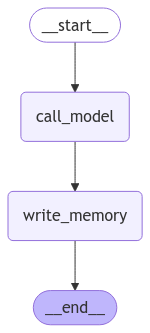

In [124]:
builder = StateGraph(ChatBotState)

builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)

builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

within_thread_memory = MemorySaver()
across_thread_memory = InMemoryStore()

graph = builder.compile(store=across_thread_memory, checkpointer=within_thread_memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [126]:
config = {"configurable" : {"user_id" : "2", "thread_id" : "2"}}

input_messages = [HumanMessage(content="Hi, I'm Lance.")]

for event in graph.stream({"messages" : input_messages}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()


================================ Human Message =================================

Hi, I'm Lance.
********************************CALL MODEL NODE********************************
State:  {'messages': [HumanMessage(content="Hi, I'm Lance.", additional_kwargs={}, response_metadata={}, id='82da1f16-8344-4cab-8033-9599cd401d2a')]}
Config:  {'metadata': {'user_id': '2', 'thread_id': '2', 'langgraph_step': 1, 'langgraph_node': 'call_model', 'langgraph_triggers': ['start:call_model'], 'langgraph_path': ('__pregel_pull', 'call_model'), 'langgraph_checkpoint_ns': 'call_model:31e7d4f4-4101-4270-211d-94fafc19d942'}, 'configurable': {'user_id': '2', 'thread_id': '2', '__pregel_resuming': False, '__pregel_task_id': '31e7d4f4-4101-4270-211d-94fafc19d942', '__pregel_send': functools.partial(<function PregelRunner.tick.<locals>.writer at 0x1212fcae0>, PregelExecutableTask(name='call_model', input={'messages': [HumanMessage(content="Hi, I'm Lance.", additional_kwargs={}, response_metadata={}, id='82da1f1

In [127]:
memories = across_thread_memory.search((config["configurable"]["user_id"], "memories"))
memories


[Item(namespace=['2', 'memories'], key='b8468ac0-96a9-4745-ab2c-5bc8d140d16d', value={'content': "User's name is Lance."}, created_at='2025-01-07T18:18:29.439521+00:00', updated_at='2025-01-07T18:18:29.439523+00:00', score=None)]

In [130]:
user_id = config["configurable"]["user_id"]
namespace= (user_id, "memories")

existing_items = across_thread_memory.search(namespace)
print("Existing Items: ", existing_items)

Existing Items:  [Item(namespace=['2', 'memories'], key='b8468ac0-96a9-4745-ab2c-5bc8d140d16d', value={'content': "User's name is Lance."}, created_at='2025-01-07T18:18:29.439521+00:00', updated_at='2025-01-07T18:18:29.439523+00:00', score=None)]


In [131]:
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
********************************CALL MODEL NODE********************************
State:  {'messages': [HumanMessage(content="Hi, I'm Lance.", additional_kwargs={}, response_metadata={}, id='82da1f16-8344-4cab-8033-9599cd401d2a'), AIMessage(content="Hi Lance! It's great to meet you. How's your day going?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 78, 'total_tokens': 94, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='run-f7c3534f-9383-4def-9cca-790ffaefb365-0', usage_metadata={'input_tokens': 78, 'output_tokens': 16, 'to

In [138]:
user_id = config["configurable"]["user_id"]
namespace= (user_id, "memories")

existing_items = across_thread_memory.search(namespace)

for item in existing_items:
    print(item.dict())
    print("---------------------------------------------------")



{'namespace': ['2', 'memories'], 'key': 'b8468ac0-96a9-4745-ab2c-5bc8d140d16d', 'value': {'content': "User's name is Lance. User enjoys biking around San Francisco."}, 'created_at': '2025-01-07T18:20:45.992657+00:00', 'updated_at': '2025-01-07T18:20:45.992658+00:00', 'score': None}
---------------------------------------------------
{'namespace': ['2', 'memories'], 'key': 'c942a613-f34a-4551-8ab1-87fdbab22ce2', 'value': {'content': 'User enjoys biking around San Francisco.'}, 'created_at': '2025-01-07T18:20:45.992691+00:00', 'updated_at': '2025-01-07T18:20:45.992691+00:00', 'score': None}
---------------------------------------------------


In [139]:
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
********************************CALL MODEL NODE********************************
State:  {'messages': [HumanMessage(content="Hi, I'm Lance.", additional_kwargs={}, response_metadata={}, id='82da1f16-8344-4cab-8033-9599cd401d2a'), AIMessage(content="Hi Lance! It's great to meet you. How's your day going?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 78, 'total_tokens': 94, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='run-f7c3534f-9383-4def-9cca-790ffaefb365-0', usage_metadata={'input_tokens': 78, 'output_tokens': 16, 'total_t

In [140]:
user_id = config["configurable"]["user_id"]
namespace= (user_id, "memories")

existing_items = across_thread_memory.search(namespace)

for item in existing_items:
    print(item.dict())
    print("---------------------------------------------------")



{'namespace': ['2', 'memories'], 'key': 'b8468ac0-96a9-4745-ab2c-5bc8d140d16d', 'value': {'content': "User's name is Lance. User enjoys biking around San Francisco. User enjoys going to bakeries."}, 'created_at': '2025-01-07T18:24:29.881000+00:00', 'updated_at': '2025-01-07T18:24:29.881001+00:00', 'score': None}
---------------------------------------------------
{'namespace': ['2', 'memories'], 'key': 'c942a613-f34a-4551-8ab1-87fdbab22ce2', 'value': {'content': 'User enjoys biking around San Francisco.'}, 'created_at': '2025-01-07T18:20:45.992691+00:00', 'updated_at': '2025-01-07T18:20:45.992691+00:00', 'score': None}
---------------------------------------------------
{'namespace': ['2', 'memories'], 'key': '948f75cb-a3c3-4847-9de1-098147252ba6', 'value': {'content': 'User enjoys going to bakeries.'}, 'created_at': '2025-01-07T18:24:29.881033+00:00', 'updated_at': '2025-01-07T18:24:29.881034+00:00', 'score': None}
---------------------------------------------------


In [141]:
config = {"configurable": {"thread_id": "3", "user_id": "2"}}

# User input 
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries do you recommend for me?
********************************CALL MODEL NODE********************************
State:  {'messages': [HumanMessage(content='What bakeries do you recommend for me?', additional_kwargs={}, response_metadata={}, id='10145050-14f7-4a9b-bd51-28d4160ec940')]}
Config:  {'metadata': {'thread_id': '3', 'user_id': '2', 'langgraph_step': 1, 'langgraph_node': 'call_model', 'langgraph_triggers': ['start:call_model'], 'langgraph_path': ('__pregel_pull', 'call_model'), 'langgraph_checkpoint_ns': 'call_model:e584eebd-933b-0b2b-e083-16b61902e592'}, 'configurable': {'thread_id': '3', 'user_id': '2', '__pregel_resuming': False, '__pregel_task_id': 'e584eebd-933b-0b2b-e083-16b61902e592', '__pregel_send': functools.partial(<function PregelRunner.tick.<locals>.writer at 0x11764a3e0>, PregelExecutableTask(name='call_model', input={'messages': [HumanMessage(content='What bakeries do you rec

In [142]:
user_id = config["configurable"]["user_id"]
namespace= (user_id, "memories")

existing_items = across_thread_memory.search(namespace)

for item in existing_items:
    print(item.dict())
    print("---------------------------------------------------")



{'namespace': ['2', 'memories'], 'key': 'b8468ac0-96a9-4745-ab2c-5bc8d140d16d', 'value': {'content': "User's name is Lance. User enjoys biking around San Francisco. User enjoys going to bakeries."}, 'created_at': '2025-01-07T18:24:29.881000+00:00', 'updated_at': '2025-01-07T18:24:29.881001+00:00', 'score': None}
---------------------------------------------------
{'namespace': ['2', 'memories'], 'key': 'c942a613-f34a-4551-8ab1-87fdbab22ce2', 'value': {'content': 'User enjoys biking around San Francisco.'}, 'created_at': '2025-01-07T18:20:45.992691+00:00', 'updated_at': '2025-01-07T18:20:45.992691+00:00', 'score': None}
---------------------------------------------------
{'namespace': ['2', 'memories'], 'key': '948f75cb-a3c3-4847-9de1-098147252ba6', 'value': {'content': 'User enjoys going to bakeries.'}, 'created_at': '2025-01-07T18:24:29.881033+00:00', 'updated_at': '2025-01-07T18:24:29.881034+00:00', 'score': None}
---------------------------------------------------
{'namespace': ['2'

In [143]:
config = {"configurable": {"thread_id": "4", "user_id": "2"}}

# User input 
input_messages = [HumanMessage(content="I love to cheesecake and tiramisu?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I love to cheesecake and tiramisu?
********************************CALL MODEL NODE********************************
State:  {'messages': [HumanMessage(content='I love to cheesecake and tiramisu?', additional_kwargs={}, response_metadata={}, id='49a6ba67-1356-4686-ac91-5007ce5a08c4')]}
Config:  {'metadata': {'thread_id': '4', 'user_id': '2', 'langgraph_step': 1, 'langgraph_node': 'call_model', 'langgraph_triggers': ['start:call_model'], 'langgraph_path': ('__pregel_pull', 'call_model'), 'langgraph_checkpoint_ns': 'call_model:5b32a06b-27fe-bd62-f5a6-a69e3223f8c1'}, 'configurable': {'thread_id': '4', 'user_id': '2', '__pregel_resuming': False, '__pregel_task_id': '5b32a06b-27fe-bd62-f5a6-a69e3223f8c1', '__pregel_send': functools.partial(<function PregelRunner.tick.<locals>.writer at 0x116c78ae0>, PregelExecutableTask(name='call_model', input={'messages': [HumanMessage(content='I love to cheesecake and tiramis